## Интерактивная визуализация
[Визуализация](https://playground.tensorflow.org)

![](https://www.cs.umd.edu/~tomg/img/landscapes/notresnet110.png)

![](http://ruder.io/content/images/2016/09/saddle_point_evaluation_optimizers.gif)

![](http://ruder.io/content/images/2016/09/contours_evaluation_optimizers.gif)

# Нейронные сети. Практика

In [1]:
# !pip install http://download.pytorch.org/whl/cu92/torch-0.4.1-cp36-cp36m-linux_x86_64.whl

In [2]:
import torch
from torch import nn
import torch.nn.functional as F

torch.cuda.is_available()

True

In [10]:
import numpy
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

RND_SEED = 7
plt.style.use('ggplot')

numpy.random.seed(RND_SEED)

%matplotlib inline

# # код ниже нужен для чтения файлов с google drive 
# from google.colab import drive
# drive.mount('/content/gdrive')


# Классификация

## Загрузка данных

Для тренеровки мы будем использовать достаточно известный набор данных [Pima Indians](http://archive.ics.uci.edu/ml/datasets/Pima+Indians+Diabetes).

Признаки такие: <br\>
1. Number of times pregnant
2. Plasma glucose concentration a 2 hours in an oral glucose tolerance test
3. Diastolic blood pressure (mm Hg)
4. Triceps skin fold thickness (mm)
5. 2-Hour serum insulin (mu U/ml)
6. Body mass index (weight in kg/(height in m)^2)
7. Diabetes pedigree function
8. Age (years)
9. Class variable (0 or 1)


In [11]:
df = pd.read_csv('../data/diabetes.csv', sep=',')
# df = pd.read_csv('/content/gdrive/My Drive/Datasets/diabetes.csv', sep=',')

In [12]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [13]:
X, y = df.iloc[:, :8].values, df.iloc[:, 8].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=RND_SEED)

In [14]:
from sklearn.preprocessing import StandardScaler

In [15]:
sc = StandardScaler().fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

In [16]:
input_features = X_train.shape[1]
input_features

8

## Составляем модель

Построим простую 2х (3х) слойную нейронную сеть. Делать это в keras одно удовольствие

In [19]:
model = nn.Sequential(
    nn.Linear(input_features, 1), # полносвязный слой с input_features нейронами на входе и 12 нейронами на выходе
#     nn.ReLU(),
#     nn.Linear(12, 8),
#     nn.ReLU(),
#     nn.Linear(8, 1),
    nn.Sigmoid()
)


# # ниже - эквивалентная форма записи. Используется для описания более сложных структур

# class Model(nn.Module):
#     def __init__(self):
#         super(Model, self).__init__()
#         self.l1 = nn.Linear(input_features, 12) # добавляем в конструктор обучаемые слои
#         self.l2 = nn.Linear(12, 8)
#         self.l3 = nn.Linear(8, 1)
        
#     def forward(self, x): # x - входной тензор (torch.Tensor)
#         x = self.l1(x)
#         x = F.relu(x)
#         x = self.l2(x)
#         x = F.relu(x)
#         x = self.l3(x)
#         return F.sigmoid(x)

# model = Model()

## Обучаем

In [20]:
# !pip install livelossplot

In [30]:
import math
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score
from livelossplot import PlotLosses

nb_epoch=500
batch_size=50
train_dataset = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)

opt = torch.optim.SGD(model.parameters(), lr=1e-2)
criterion = nn.BCELoss() # Binary cross-entropy loss

liveloss = PlotLosses()

for epoch in range(nb_epoch):
    print('Epoch: %d' % epoch)
    loss_train = []
    acc_train = []
    for batch_X, batch_y in train_loader:
        preds = model(batch_X)
        loss = criterion(preds, batch_y) # считаем ошибку
        loss_train.append(loss.item())
        loss.backward() # обратное распространение ошибки
        opt.step() # шаг градиентного спуска
        opt.zero_grad() # обнуление градиентов
        acc_train.append(accuracy_score(preds.squeeze().round().detach().numpy(), batch_y.detach().numpy()))
                            
    loss_train = np.mean(loss_train)
    acc_train = np.mean(acc_train)
    
    with torch.no_grad(): # говорим pytorch, что здесь не нужно хранить градиенты
        preds = model(torch.Tensor(X_test))
        loss_test = criterion(preds, torch.Tensor(y_test)).item()
        acc_test = accuracy_score(preds.squeeze().round(), y_test)
    
    liveloss.update({
        'loss': loss_train,
        'val_loss': loss_test,
        'accuracy': acc_train,
        'val_accuracy': acc_test
    })
    liveloss.draw()
    

KeyboardInterrupt: 

## Оценка качества

In [31]:
from sklearn.metrics import roc_auc_score
# roc_auc_score(y_hat, y_test)

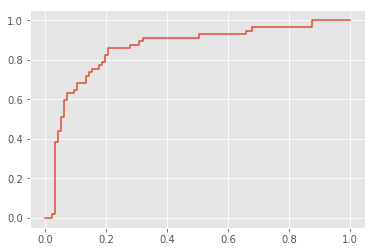

In [32]:
fpr, tpr, _ = roc_curve(y_test, preds.squeeze())
plt.plot(fpr, tpr, label='test')

# Регрессия

Будем строить регрессию на данных [Boston Housing Data Set](https://archive.ics.uci.edu/ml/datasets/Housing)

Описание:<br\>
1. CRIM: per capita crime rate by town
2. ZN: proportion of residential land zoned for lots over 25,000 sq.ft.
3. INDUS: proportion of non-retail business acres per town
4. CHAS: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
5. NOX: nitric oxides concentration (parts per 10 million)
6. RM: average number of rooms per dwelling
7. AGE: proportion of owner-occupied units built prior to 1940
8. DIS: weighted distances to five Boston employment centres
9. RAD: index of accessibility to radial highways
10. TAX: full-value property-tax rate per 10,000 USD
11. PTRATIO: pupil-teacher ratio by town
12. B: 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
13. LSTAT: lower status of the population
14. MEDV: Median value of owner-occupied homes in 1000's USD

Весь pipeline практически повторяется. Ну и повторим.

In [31]:
from sklearn import datasets

In [32]:
boston = datasets.load_boston()

In [33]:
y = boston.target

In [34]:
X = boston.data

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=RND_SEED)

In [36]:
sc = StandardScaler().fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

In [37]:
input_features = X_train.shape[1]
input_features

13

## Составляем модель

Построим простую 2х (3х) слойную нейронную сеть. Делать это в keras одно удовольствие

In [38]:
model = nn.Sequential(
    nn.Linear(input_features, 12), # полносвязный слой с input_features нейронами на входе и 12 нейронами на выходе
    nn.ReLU(),
    nn.Linear(12, 8),
    nn.ReLU(),
    nn.Linear(8, 2),
#     nn.Sigmoid()
)

# # ниже - эквивалентная форма записи. Используется для описания более сложных структур

# class Model(nn.Module):
#     def __init__(self):
#         super(Model, self).__init__()
#         self.l1 = nn.Linear(input_features, 12) # добавляем в конструктор обучаемые слои
#         self.l2 = nn.Linear(12, 8)
#         self.l3 = nn.Linear(8, 1)
        
#     def forward(self, x): # x - входной тензор (torch.Tensor)
#         x = self.l1(x)
#         x = F.relu(x)
#         x = self.l2(x)
#         x = F.relu(x)
#         x = self.l3(x)
##         return F.sigmoid(x)
#         return x

# model = Model()

## Обучаем

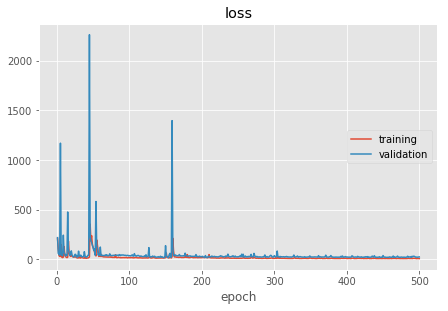

loss:
training   (min:    5.164, max:  352.779, cur:    5.640)
validation (min:   16.094, max: 2262.569, cur:   22.029)


In [45]:
import math
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score
from livelossplot import PlotLosses

nb_epoch=500
batch_size=50
train_dataset = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().squeeze())
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)

opt = torch.optim.SGD(model.parameters(), lr=1e-2)
criterion = nn.MSELoss() # Binary cross-entropy loss

liveloss = PlotLosses()

for epoch in range(nb_epoch):
    print('Epoch: %d' % epoch)
    loss_train = []
    for batch_X, batch_y in train_loader:
        preds = model(batch_X).squeeze()
        loss = criterion(preds, batch_y) # считаем ошибку
        loss_train.append(loss.item())
        loss.backward() # обратное распространение ошибки
        opt.step() # шаг градиентного спуска
        opt.zero_grad() # обнуление градиентов
                            
    loss_train = np.mean(loss_train)
    
    with torch.no_grad(): # говорим pytorch, что здесь не нужно хранить градиенты
        preds = model(torch.Tensor(X_test)).squeeze()
        loss_test = criterion(preds, torch.Tensor(y_test)).item()
        
    liveloss.update({
        'loss': loss_train,
        'val_loss': loss_test
    })
    liveloss.draw()
    

In [41]:
model[0].weight.data = torch.Tensor()

Parameter containing:
tensor([[-0.0810, -0.1064, -0.1563, -0.0687, -0.2695, -0.1908,  0.0481,
         -0.2032, -0.1809,  0.1687, -0.1725, -0.1485, -0.1034],
        [ 0.1913, -0.1839,  0.2319,  0.0783,  0.0593, -0.1875,  0.1612,
          0.0182, -0.0018,  0.2566,  0.1172,  0.0007,  0.2047],
        [ 0.1900,  0.0136, -0.1870,  0.0262,  0.1383, -0.2177,  0.2689,
         -0.2101, -0.2396, -0.1266,  0.0876,  0.0111, -0.0451],
        [ 0.0727,  0.0912,  0.1066, -0.2248,  0.0145, -0.2026,  0.1411,
          0.2769, -0.0035,  0.0379, -0.0726,  0.2261, -0.0666],
        [ 0.2132, -0.1107,  0.2490,  0.1723, -0.0096, -0.0735, -0.1398,
         -0.0722,  0.0234,  0.2645,  0.0347, -0.0033,  0.0694],
        [ 0.0053, -0.1161,  0.1291,  0.2094, -0.1581, -0.2364,  0.2115,
          0.2444,  0.0890, -0.0728, -0.1002,  0.0213,  0.1367],
        [-0.0587,  0.2518,  0.2005,  0.0574,  0.2509, -0.1722, -0.1447,
          0.0908, -0.1486,  0.2684, -0.1939, -0.0034,  0.2456],
        [-0.1895, -0.1278,

# Конволюционные нейронные сети

<img src='http://i.stack.imgur.com/oUwMk.png'>

Загрузите архив [отсюда](https://github.com/lucastheis/deepbelief/blob/master/data/mnist.npz)

In [73]:
# !wget https://github.com/lucastheis/deepbelief/blob/master/data/mnist.npz .

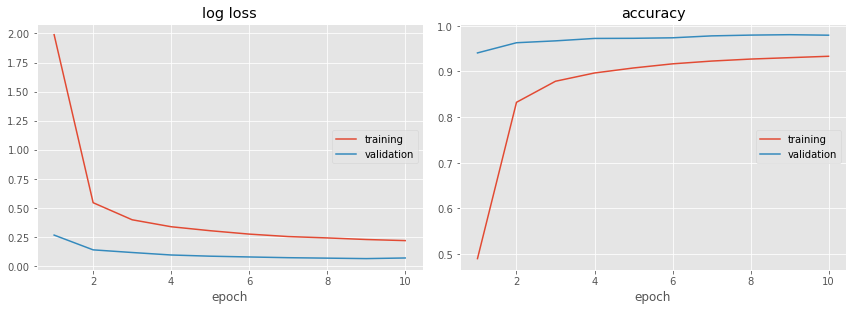

log loss:
training   (min:    0.219, max:    1.989, cur:    0.219)
validation (min:    0.064, max:    0.266, cur:    0.069)

accuracy:
training   (min:    0.490, max:    0.933, cur:    0.933)
validation (min:    0.941, max:    0.981, cur:    0.980)
Accuracy: 0.9795 (test), 0.9333 (train)


In [69]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from livelossplot import PlotLosses

#device = torch.device("cpu") # Uncomment this to run on CPU
device = torch.device("cuda:0") # Uncomment this to run on GPU

n_classes = 10

def create_dataset(x, y, flatten=False):
    if flatten:
        # Convert it into a matrix (N [samples], 28*28 [dims])
        xt = torch.from_numpy(x).view(len(x), -1)
    else:
        # Convert it into a 4D tensor (N [samples], 1 [ch], 28 [px], 28 [px])
        xt = torch.from_numpy(x).unsqueeze(1)
    yt = torch.from_numpy(y).long()
    return TensorDataset(xt.float(), yt.float())

def test_model(model, loss_fn, test_loader, device):
    model.eval()

    loss = 0.
    num_correct = 0.
    for batch_idx, (x, y) in enumerate(test_loader):
        x, y = x.to(device), y.to(device).squeeze().long()
        y_pred = model(x)
        loss += loss_fn(y_pred, y).item()
        _, predicted = torch.max(y_pred.data, 1)
        num_correct += (predicted == y).sum().item()

    model.train()
    loss /= len(test_loader.dataset)
    num_correct /= len(test_loader.dataset)
    return loss, num_correct

class Flatten(torch.nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        return x.view(-1, 512)

model = torch.nn.Sequential(
    torch.nn.Conv2d(1, 16, (5, 5)),
    torch.nn.MaxPool2d(2),
    torch.nn.ReLU(),
    torch.nn.Dropout(),
    torch.nn.Conv2d(16, 32, (5, 5)),
    torch.nn.MaxPool2d(2),    
    torch.nn.ReLU(),
    torch.nn.Dropout(),
    Flatten(),
    torch.nn.Linear(512, 256),
    torch.nn.ReLU(),
    torch.nn.Dropout(),
    torch.nn.Linear(256, 10),
)

model.to(device)

data = np.load('../data/mnist.npz')
train_set = create_dataset(data['train'].transpose().reshape(-1,28,28), data['train_labels'].transpose())
test_set = create_dataset(data['test'].transpose().reshape(-1,28,28), data['test_labels'].transpose())
train_loader = DataLoader(train_set, batch_size=256, shuffle=True)
test_loader = DataLoader(test_set, batch_size=128)

loss_fn = nn.CrossEntropyLoss(size_average=False)
optimizer = optim.SGD(model.parameters(), lr=1e-4)

liveloss = PlotLosses()
for epoch in range(10):
    print('Epoch: %d' % epoch)
    train_loss = 0.
    train_correct = 0
    
    # Training loop for mini-batches
    for batch_idx, (x, y) in enumerate(train_loader):
        # Make predictions with the current parameters.
        x, y = x.to(device), y.to(device).squeeze()
        y_pred = model(x)
        _, predicted = torch.max(y_pred.data, 1)
        train_correct += (predicted.long() == y.long()).sum().item()
        
        # Compute the loss value.
        loss = loss_fn(y_pred.float(), y.long())
        train_loss += loss.item()

        # Update the parameters.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Compute the average loss and accuracy.
    train_loss /= len(train_loader.dataset)
    train_correct /= float(len(train_loader.dataset))
    
    # Evaluate the model on the test set.
    test_loss, test_correct = test_model(model, loss_fn, test_loader, device)

    # Visualize the loss and accuracy values.
    liveloss.update({
        'log loss': train_loss,
        'val_log loss': test_loss,
        'accuracy': train_correct,
        'val_accuracy': test_correct,
    })
    liveloss.draw()
    
print('Accuracy: {:.4f} (test), {:.4f} (train)'.format(test_correct, train_correct))

Посмотрим на данные

# Цветные картинки

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms

train_batch_size = 32
test_batch_size = 124
best_loss = float("inf")
best_epoch = -1
dataset_path = '../data/cifar10'

## Аугментация

Сеть должна уметь выполнять классификацию не зависимо от того, повернут ли объект, уменьшен он или увеличен и тп.
То есть в обучающей выборке должны содержаться такие элементарные трансформации. Кроме того, это совершенно бесплатно вам позволяет очень сильно увеличить размер вашей обучающей выборки (и притом ещё и разнообразить её новыми примерами). В случае с картинками это особо важно, потому что каждая размеченная картинка, как правило, "на вес золота"

In [2]:
trainset = datasets.CIFAR10(root=dataset_path, train=True, download=True)
train_mean = trainset.train_data.mean(axis=(0,1,2))/255  # [0.49139968  0.48215841  0.44653091]
train_std = trainset.train_data.std(axis=(0,1,2))/255  # [0.24703223  0.24348513  0.26158784]
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(train_mean, train_std),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(train_mean, train_std),
])
train_loader = torch.utils.data.DataLoader(datasets.CIFAR10(
    root=dataset_path, train=True, download=True,
    transform=transform_train),
    batch_size=train_batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(root=dataset_path, train=False, download=True,
    transform=transform_test),
    batch_size=test_batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


Далее, продолжаем по https://github.com/fchollet/keras/blob/master/examples/cifar10_cnn.py

## Обучение

In [10]:
#device = torch.device("cpu") # Uncomment this to run on CPU
device = torch.device("cuda:0") # Uncomment this to run on GPU

n_classes = 10

class Flatten(torch.nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        return x.view(x.shape[0], -1)


model = torch.nn.Sequential(
    torch.nn.Conv2d(3, 16, (5, 5)),
    torch.nn.MaxPool2d(2),
    torch.nn.ReLU(),
    torch.nn.Dropout(),
    torch.nn.Conv2d(16, 32, (5, 5)),
    torch.nn.MaxPool2d(2),    
    torch.nn.ReLU(),
    torch.nn.Dropout(),
    Flatten(),
    torch.nn.Linear(800, 256),
    torch.nn.ReLU(),
    torch.nn.Dropout(),
    torch.nn.Linear(256, 10),
).to(device)

criterion = nn.CrossEntropyLoss()
opt = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

In [15]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        opt.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        opt.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))
            
def test(epoch, best_loss, best_epoch):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        
        output = model(data)
        # sum up batch loss
        test_loss += criterion(output, target).data[0]
        # get the index of the max log-probability
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()

    test_loss /= len(test_loader.dataset)
    print(
        '\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset), 100. * correct /
            len(test_loader.dataset)))
    
##     для сохра
#     if test_loss < best_loss:
#         best_epoch = epoch
#         best_loss = test_loss
#         torch.save(model, "best.pt")
#         if gsync_save:
#             gsync.update_file_to_folder("best.pt")
    return best_loss, best_epoch

In [16]:
for epoch in range(10):
    train(epoch)
    best_loss, best_epoch = test(epoch, best_loss, best_epoch)

/home/artem/anaconda3/envs/pytorch_3.6/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  del sys.path[0]


Train Epoch: 0 [0/50000 (0%)]	Loss: 1.899726
Train Epoch: 0 [3200/50000 (6%)]	Loss: 2.056948
Train Epoch: 0 [6400/50000 (13%)]	Loss: 1.732126
Train Epoch: 0 [9600/50000 (19%)]	Loss: 1.843653
Train Epoch: 0 [12800/50000 (26%)]	Loss: 1.812793
Train Epoch: 0 [16000/50000 (32%)]	Loss: 1.794552
Train Epoch: 0 [19200/50000 (38%)]	Loss: 1.791229
Train Epoch: 0 [22400/50000 (45%)]	Loss: 2.034439
Train Epoch: 0 [25600/50000 (51%)]	Loss: 1.866062
Train Epoch: 0 [28800/50000 (58%)]	Loss: 1.976375
Train Epoch: 0 [32000/50000 (64%)]	Loss: 1.836805
Train Epoch: 0 [35200/50000 (70%)]	Loss: 1.666337
Train Epoch: 0 [38400/50000 (77%)]	Loss: 1.964420
Train Epoch: 0 [41600/50000 (83%)]	Loss: 1.624720
Train Epoch: 0 [44800/50000 (90%)]	Loss: 1.871456
Train Epoch: 0 [48000/50000 (96%)]	Loss: 1.928681


/home/artem/anaconda3/envs/pytorch_3.6/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number



Test set: Average loss: 0.0131, Accuracy: 4365/10000 (43%)

Train Epoch: 1 [0/50000 (0%)]	Loss: 1.516556
Train Epoch: 1 [3200/50000 (6%)]	Loss: 1.790110
Train Epoch: 1 [6400/50000 (13%)]	Loss: 1.634391
Train Epoch: 1 [9600/50000 (19%)]	Loss: 1.676216
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.853363
Train Epoch: 1 [16000/50000 (32%)]	Loss: 1.511915
Train Epoch: 1 [19200/50000 (38%)]	Loss: 1.945287
Train Epoch: 1 [22400/50000 (45%)]	Loss: 1.845023
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.620026
Train Epoch: 1 [28800/50000 (58%)]	Loss: 1.683776
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.784438
Train Epoch: 1 [35200/50000 (70%)]	Loss: 1.650676
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.629941
Train Epoch: 1 [41600/50000 (83%)]	Loss: 1.752902
Train Epoch: 1 [44800/50000 (90%)]	Loss: 1.914457
Train Epoch: 1 [48000/50000 (96%)]	Loss: 1.605628

Test set: Average loss: 0.0126, Accuracy: 4553/10000 (45%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.386163
Train Epoch: 2 [3200/50000 (6%)]	Loss: 1.6

### Полезные ссылки
* https://habr.com/post/348058/ - Мануал по получению бесплатной GPU на Google.Colab
* https://www.dlology.com/blog/how-to-run-pytorch-with-gpu-and-cuda-92-support-on-google-colab/ - Установка PyTorch и CUDA на Google.Colab
* https://colab.research.google.com/github/chokkan/deeplearningclass/blob/master/mnist.ipynb - MNIST на Pytorch и Google.Colab
* https://colab.research.google.com/github/StefOe/all-conv-pytorch/blob/master/cifar10.ipynb - CIFAR10 на Pytorch и Google.Colab
* https://www.youtube.com/watch?v=WjwA5DqxL-c - Лекция К.В, Воронцова "Нейронные сети"
* http://ruder.io/optimizing-gradient-descent/ - обзор современных методов градиентного спуска